In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import shap
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'
] = (12,
6)

In [51]:
df = pd.read_csv('../data/processed/player_features.csv')

print(f"   Dataset loaded!")
print(f"   Total records: {len(df)}")
print(f"   Columns: {len(df.columns)}")
print(f"   Date range: {df['season'].min()} to {df['season'].max()}")
print(f"\n   Column names:")

df.head()

   Dataset loaded!
   Total records: 2675
   Columns: 14
   Date range: 2020-21 to 2024-25

   Column names:


,player_name,team,season,age,position,games_played,minutes_per_game,points_per_game,rebounds_per_game,assists_per_game,points_per_minute,assist_rate,rebound_rate,target_next_season_ppg
0,A.J. Green,MIL,2022-23,23,SG,35,9.857143,4.400000,1.285714,0.628571,0.446377,0.063768,0.130435,4.500000
1,A.J. Green,MIL,2023-24,24,SG,56,10.964286,4.500000,1.142857,0.535714,0.410423,0.048860,0.104235,7.410959
2,A.J. Lawson,2TM,2022-23,22,SG,15,7.200000,3.733333,1.400000,0.133333,0.518519,0.018519,0.194444,2.000000
3,A.J. Lawson,MIN,2022-23,22,SG,1,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.500000,3.857143
4,A.J. Lawson,DAL,2022-23,22,SG,14,7.571429,3.857143,1.428571,0.142857,0.509434,0.018868,0.188679,3.238095


 Missing Values:
player_name               0
team                      0
season                    0
age                       0
position                  0
games_played              0
minutes_per_game          0
points_per_game           0
rebounds_per_game         0
assists_per_game          0
points_per_minute         0
assist_rate               0
rebound_rate              0
target_next_season_ppg    0
dtype: int64

 Target Variable Statistics:
count    2675.000000
mean        8.844789
std         6.507019
min         0.000000
25%         4.064516
50%         7.108696
75%        11.902381
max        34.692308
Name: target_next_season_ppg, dtype: float64


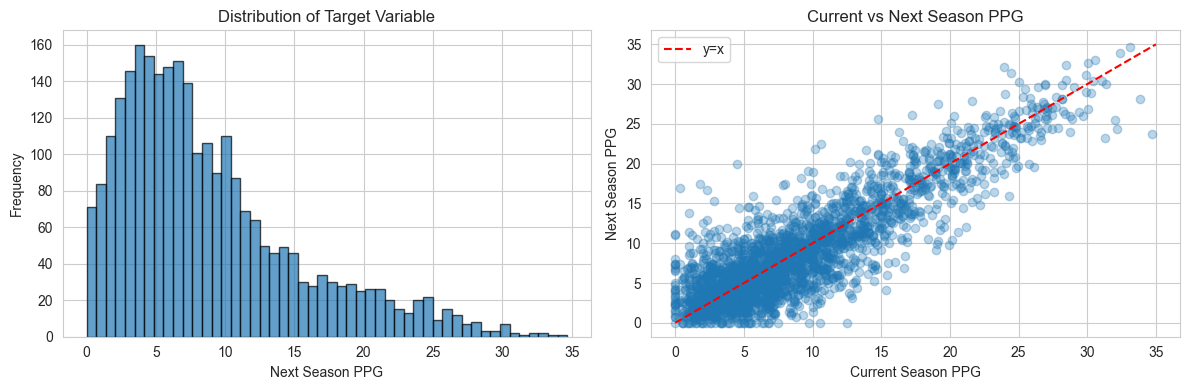

In [52]:
print(" Missing Values:")
print(df.isnull().sum())

# Basic statistics
print("\n Target Variable Statistics:")
print(df['target_next_season_ppg'
].describe())

# Distribution of target variable
plt.figure(figsize=(12,
4))

plt.subplot(1,
2,
1)
plt.hist(df['target_next_season_ppg'
], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Next Season PPG')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')

plt.subplot(1,
2,
2)
plt.scatter(df['points_per_game'
], df['target_next_season_ppg'
], alpha=0.3)
plt.xlabel('Current Season PPG')
plt.ylabel('Next Season PPG')
plt.title('Current vs Next Season PPG')
plt.plot([
    0,
    35
],
[
    0,
    35
], 'r--', label='y=x')
plt.legend()

plt.tight_layout()
plt.show()

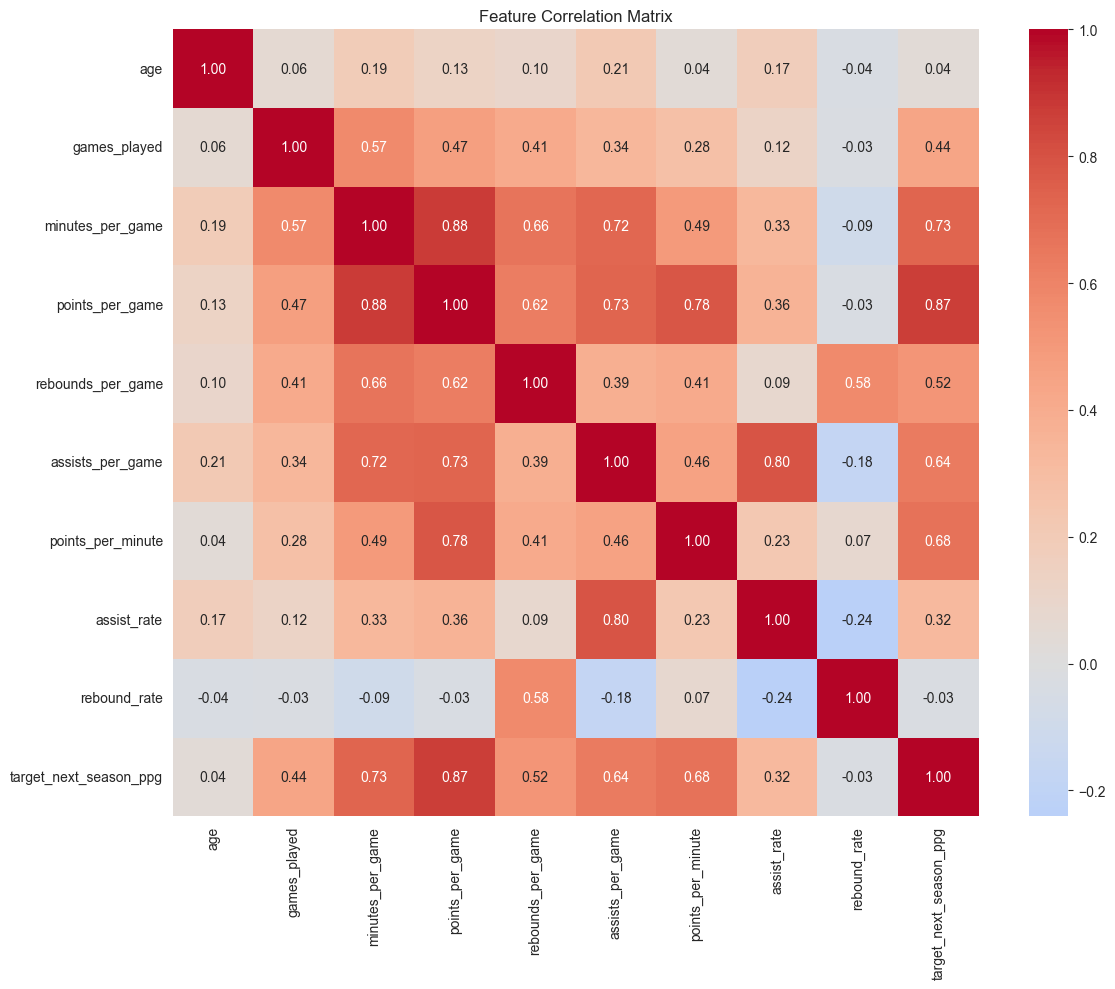


 Correlation with Target (Next Season PPG):
target_next_season_ppg    1.000000
points_per_game           0.871802
minutes_per_game          0.733191
points_per_minute         0.676076
assists_per_game          0.636677
rebounds_per_game         0.524050
games_played              0.438286
assist_rate               0.323560
age                       0.036531
rebound_rate             -0.025824
Name: target_next_season_ppg, dtype: float64


In [53]:
numeric_features = [
    'age',
    'games_played',
    'minutes_per_game',
    'points_per_game',
    'rebounds_per_game',
    'assists_per_game',
    'points_per_minute',
    'assist_rate',
    'rebound_rate',
    'target_next_season_ppg'
]

# Correlation matrix
correlation_matrix = df[numeric_features
].corr()

plt.figure(figsize=(12,
10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("\n Correlation with Target (Next Season PPG):")
target_corr = correlation_matrix['target_next_season_ppg'
].sort_values(ascending=False)
print(target_corr)

In [54]:
feature_columns = [
    'age',
    'games_played',
    'minutes_per_game',
    'points_per_game',
    'rebounds_per_game',
    'assists_per_game',
    'points_per_minute',
    'assist_rate',
    'rebound_rate'
]

# Prepare X and y
X = df[feature_columns
]
y = df['target_next_season_ppg'
]

print(f"   Features prepared:")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"\n   Feature columns:")
for i, col in enumerate(feature_columns,
1):
    print(f"      {i}. {col}")

   Features prepared:
   X shape: (2675, 9)
   y shape: (2675,)

   Feature columns:
      1. age
      2. games_played
      3. minutes_per_game
      4. points_per_game
      5. rebounds_per_game
      6. assists_per_game
      7. points_per_minute
      8. assist_rate
      9. rebound_rate


In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f" Data Split:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Split ratio: 80/20")

 Data Split:
   Training set: 2140 samples
   Test set: 535 samples
   Split ratio: 80/20


In [56]:
print("Training XGBoost model...")

model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1
)

# Train with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

# Get best iteration (manual early stopping)
best_iteration = model.best_iteration if hasattr(model, 'best_iteration') else model.n_estimators

print(f"\n Training complete!")
print(f"   Best iteration: {best_iteration}")

Training XGBoost model...
[0]	validation_0-rmse:6.17388	validation_1-rmse:6.63615
[50]	validation_0-rmse:2.75922	validation_1-rmse:3.38561
[99]	validation_0-rmse:2.56539	validation_1-rmse:3.33924

 Training complete!
   Best iteration: 100


In [57]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("=" * 60)
print(" MODEL PERFORMANCE")
print("=" * 60)
print(f"\n{'Metric':<20} {'Training':<15} {'Test':<15}")
print("-" * 60)
print(f"{'MAE (PPG)':<20} {train_mae:<15.3f} {test_mae:<15.3f}")
print(f"{'RMSE (PPG)':<20} {train_rmse:<15.3f} {test_rmse:<15.3f}")
print(f"{'R² Score':<20} {train_r2:<15.3f} {test_r2:<15.3f}")
print("=" * 60)

# Check for overfitting
if abs(train_mae - test_mae) < 0.5:
    print("\n Model is well-balanced (no significant overfitting)")
elif test_mae > train_mae * 1.2:
    print("\n Possible overfitting detected")
else:
    print("\n Model performance is acceptable")

 MODEL PERFORMANCE

Metric               Training        Test           
------------------------------------------------------------
MAE (PPG)            1.980           2.606          
RMSE (PPG)           2.565           3.339          
R² Score             0.840           0.764          

 Possible overfitting detected


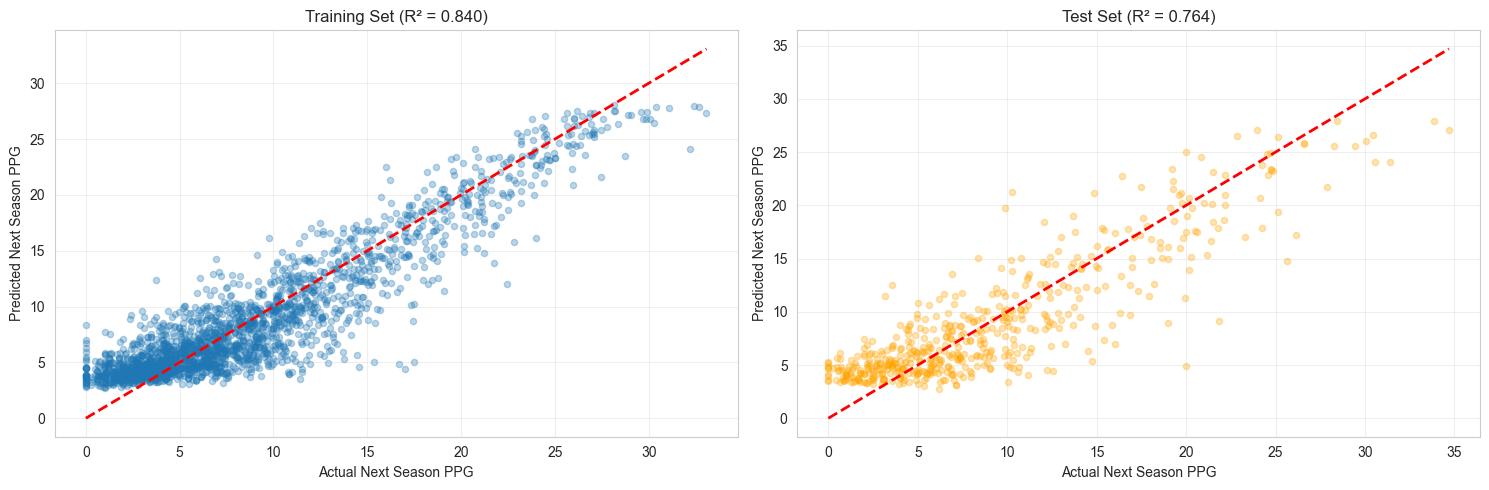

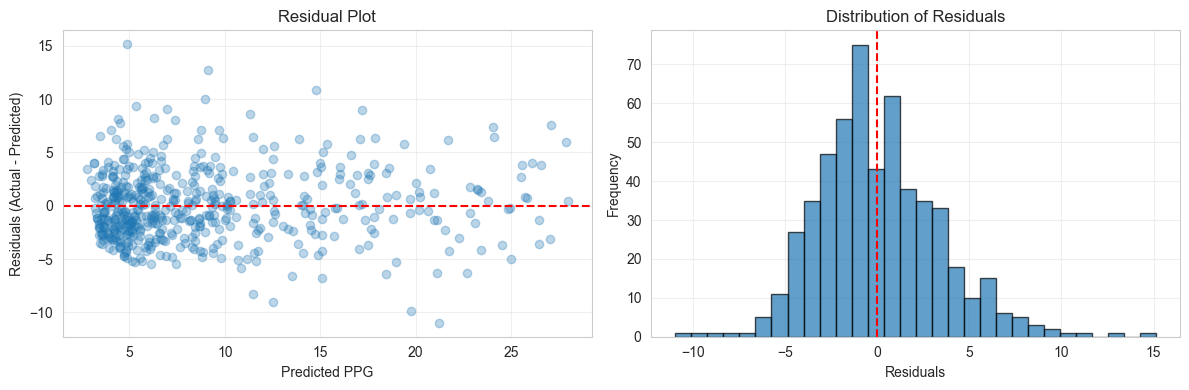

In [58]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1,
2, figsize=(15,
5))

# Training set
axes[
    0
].scatter(y_train, y_train_pred, alpha=0.3, s=20)
axes[
    0
].plot([y_train.min(), y_train.max()
],
[y_train.min(), y_train.max()
], 'r--', lw=2)
axes[
    0
].set_xlabel('Actual Next Season PPG')
axes[
    0
].set_ylabel('Predicted Next Season PPG')
axes[
    0
].set_title(f'Training Set (R² = {train_r2:.3f
})')
axes[
    0
].grid(True, alpha=0.3)

# Test set
axes[
    1
].scatter(y_test, y_test_pred, alpha=0.3, s=20, c='orange')
axes[
    1
].plot([y_test.min(), y_test.max()
],
[y_test.min(), y_test.max()
], 'r--', lw=2)
axes[
    1
].set_xlabel('Actual Next Season PPG')
axes[
    1
].set_ylabel('Predicted Next Season PPG')
axes[
    1
].set_title(f'Test Set (R² = {test_r2:.3f
})')
axes[
    1
].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residuals plot
residuals = y_test - y_test_pred

plt.figure(figsize=(12,
4))

plt.subplot(1,
2,
1)
plt.scatter(y_test_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted PPG')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1,
2,
2)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


 Feature Importance (Top to Bottom):
          feature  importance
  points_per_game    0.535815
 minutes_per_game    0.251838
points_per_minute    0.099640
     games_played    0.031611
 assists_per_game    0.025244
              age    0.020602
     rebound_rate    0.012194
      assist_rate    0.011702
rebounds_per_game    0.011354


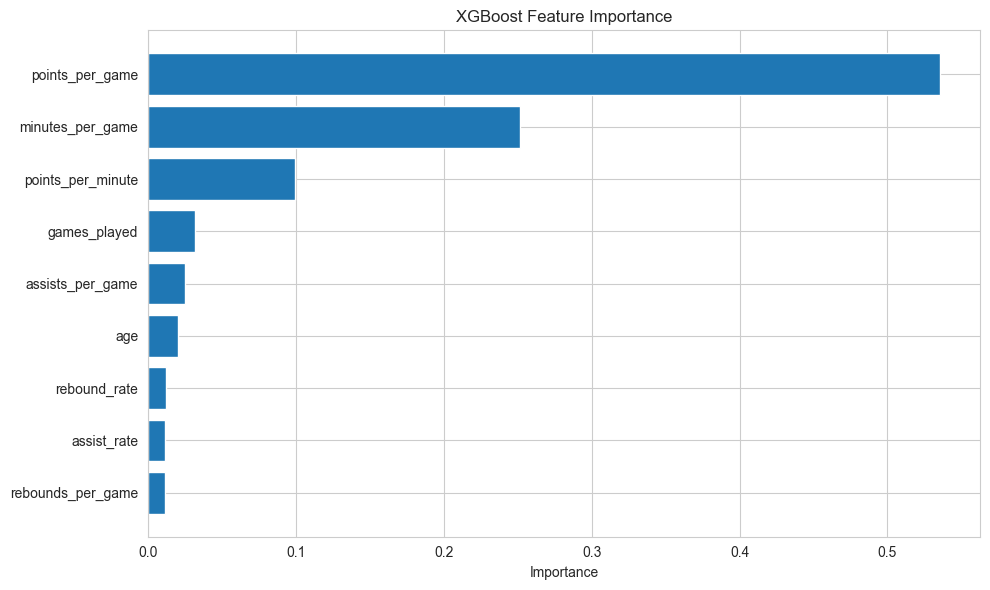

In [59]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Feature Importance (Top to Bottom):")
print(feature_importance.to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10,
6))
plt.barh(feature_importance['feature'
], feature_importance['importance'
])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

 SHAP values calculated!


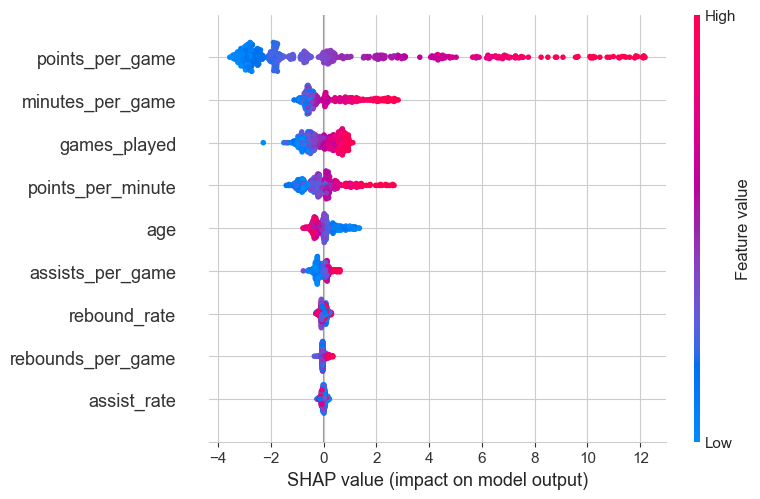

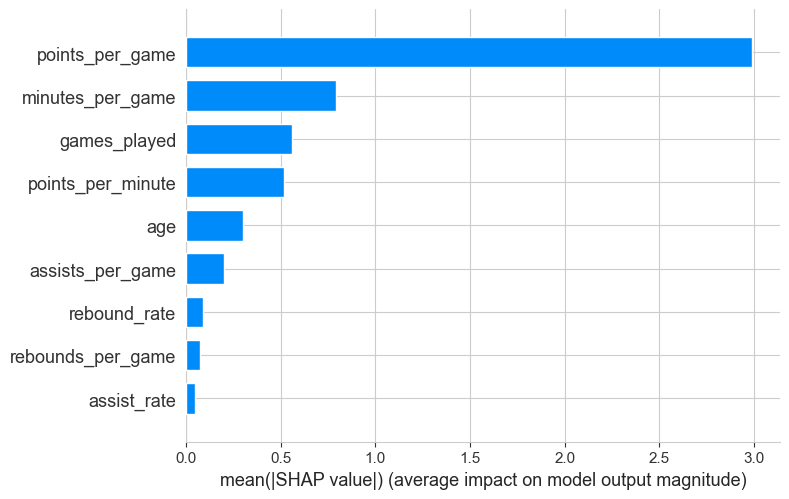

In [60]:
# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

print(" SHAP values calculated!")

# SHAP Summary Plot
plt.figure(figsize=(12,
8))
shap.summary_plot(shap_values, X_test, feature_names=feature_columns, show=False)
plt.tight_layout()
plt.show()

# SHAP Feature Importance
plt.figure(figsize=(10,
6))
shap.summary_plot(shap_values, X_test, feature_names=feature_columns, 
                  plot_type="bar", show=False)
plt.tight_layout()
plt.show()

In [61]:
# Show some example predictions
test_df = df.iloc[X_test.index
].copy()
test_df['predicted_ppg'
] = y_test_pred
test_df['actual_ppg'
] = y_test
test_df['error'
] = test_df['actual_ppg'
] - test_df['predicted_ppg'
]
test_df['abs_error'
] = abs(test_df['error'
])

print("\n  Best Predictions (lowest error):")
best_preds = test_df.nsmallest(10, 'abs_error')[
    ['player_name', 'team', 'season', 'points_per_game', 'predicted_ppg', 'actual_ppg', 'error'
    ]
]
print(best_preds.to_string(index=False))

print("\n  Worst Predictions (highest error):")
worst_preds = test_df.nlargest(10, 'abs_error')[
    ['player_name', 'team', 'season', 'points_per_game', 'predicted_ppg', 'actual_ppg', 'error'
    ]
]
print(worst_preds.to_string(index=False))


  Best Predictions (lowest error):
           player_name team  season  points_per_game  predicted_ppg  actual_ppg     error
     De'Anthony Melton  MEM 2021-22        10.835616      10.127795   10.129870  0.002075
   Dorian Finney-Smith  DAL 2022-23         9.125000       7.156593    7.153846 -0.002747
           Jalen Smith  IND 2022-23         9.441176       9.868808    9.852459 -0.016349
Thanasis Antetokounmpo  MIL 2020-21         2.912281       3.535234    3.562500  0.027266
           Matt Thomas  UTA 2020-21         3.578947       4.062010    4.025000 -0.037010
            OG Anunoby  TOR 2023-24        15.111111      14.086539   14.130435  0.043896
        Andrew Wiggins  GSW 2021-22        17.205479      17.032511   17.108108  0.075597
          Torrey Craig  2TM 2021-22         6.615385       6.343051    6.450980  0.107929
         Marcus Morris  PHI 2023-24         6.675676       5.640998    5.750000  0.109002
          Bobby Portis  MIL 2021-22        14.611111      13.989

In [62]:
print("\n Performing 5-Fold Cross-Validation...")

# Create a NEW model without early stopping for CV
cv_model = xgb.XGBRegressor(
    n_estimators=best_iteration,  # Use best iteration from training
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1
)

cv_scores = cross_val_score(
    cv_model, X, y,  # Use cv_model instead of model
    cv=5, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

cv_mae_scores = -cv_scores

print(f"\n Cross-Validation Results:")
print(f"   Mean MAE: {cv_mae_scores.mean():.3f} PPG")
print(f"   Std MAE:  {cv_mae_scores.std():.3f} PPG")
print(f"   Min MAE:  {cv_mae_scores.min():.3f} PPG")
print(f"   Max MAE:  {cv_mae_scores.max():.3f} PPG")


 Performing 5-Fold Cross-Validation...

 Cross-Validation Results:
   Mean MAE: 2.346 PPG
   Std MAE:  0.085 PPG
   Min MAE:  2.245 PPG
   Max MAE:  2.466 PPG


In [63]:
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save XGBoost model
model_path = '../models/player_xgb_v1.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f" Model saved to: {model_path}")

# Save SHAP explainer
explainer_path = '../models/shap_explainer_v1.pkl'
with open(explainer_path, 'wb') as f:
    pickle.dump(explainer, f)
print(f" SHAP explainer saved to: {explainer_path}")

# Save feature names
feature_names_path = '../models/feature_names.txt'
with open(feature_names_path, 'w') as f:
    f.write('\n'.join(feature_columns))
print(f" Feature names saved to: {feature_names_path}")

# Save model metadata
metadata = {
    'model_version': 'v1',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_features': len(feature_columns),
    'n_samples_train': len(X_train),
    'n_samples_test': len(X_test),
    'test_mae': float(test_mae),
    'test_rmse': float(test_rmse),
    'test_r2': float(test_r2),
    'cv_mean_mae': float(cv_mae_scores.mean()),
    'cv_std_mae': float(cv_mae_scores.std())
}

import json
metadata_path = '../models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f" Metadata saved to: {metadata_path}")

print("\n" + "=" * 60)
print(" MODEL TRAINING COMPLETE!")
print("=" * 60)
print(f"\n Saved Files:")
print(f"   1. {model_path}")
print(f"   2. {explainer_path}")
print(f"   3. {feature_names_path}")
print(f"   4. {metadata_path}")
print("\n Ready for deployment!")

 Model saved to: ../models/player_xgb_v1.pkl
 SHAP explainer saved to: ../models/shap_explainer_v1.pkl
 Feature names saved to: ../models/feature_names.txt
 Metadata saved to: ../models/model_metadata.json

 MODEL TRAINING COMPLETE!

 Saved Files:
   1. ../models/player_xgb_v1.pkl
   2. ../models/shap_explainer_v1.pkl
   3. ../models/feature_names.txt
   4. ../models/model_metadata.json

 Ready for deployment!
